# L-layer Feed Forward Neural Network
The purpose of this project is to build Deep Feed Forward Neural Network from scratch in python.

After the network is built, it will be trained using images of cats and dogs in order to learn the mapping from the inputs to the output and classify them correctly.

Feed Forward Neural network is not the best choice for image classification and is significantly inferior to Convolutional Neural Network. It's merely used for the purpose of showing how it works.

In [1]:
# Import libraries
import os
import time
import numpy as np
import pandas as pd
import random
import zipfile
import cv2

# Visualiztion
import matplotlib.pyplot as plt
import seaborn as sns

### Toy Dataset
This dataset will be used to check the correctness of the neural network before applaying other dataset containing images of cats and dogs.

In [2]:
# Data
x = np.array([  [0,0,1],
                [0,1,1],
                [1,0,1],
                [1,1,1]  ]).T

y = np.array([[0,0,1,1]])

### Acivation Functions
Activation functions which will be used in our model.

**Relu:**

This activation function turns all negative values into 0s and all positive stay the same

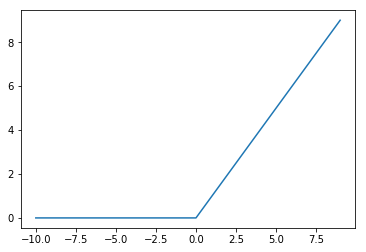

In [3]:
def relu(x, deriv=False):
    if deriv:
        return 1. * (x > 0)
    else:
        return np.maximum(0,x)

j = np.arange(20)-10
    
plt.plot(j, relu(j))
plt.show()

**Sigmoid:**

This function (description here, with math)

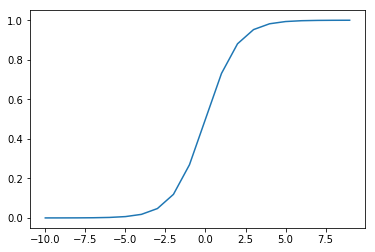

In [4]:
def sigmoid(x, deriv=False):
    if deriv:
        return (1/(1 + np.exp(-x))) * (1-(1/(1 + np.exp(-x))))
    else:
        return 1/(1 + np.exp(-x))
    
j = np.arange(20) - 10

plt.plot(j, sigmoid(j))
plt.show()

### Building the network

**Initialize parameters for an L-layer neural network**

Initialize weights and biases given **layer_dims** variable. For instance a network with dimensions of $[4, 3, 1]$ will be 2 layers deep because the input layer $[4]$ is ommited and isn't included in the numer of layers. The network will therefore have 2 sets of weights and biases with dimensions of $W^{[1]} = [3, 4], b^{[1]} = [3, 1], W^{[2]} = [1, 3], b^{[2]} = [1, 1]$.

- Input layer [4] is ommited and doesn't add up to the numer of layers.
- Dimensions of $W[l] = [l, l - 1]$ while the dimensions of $b[l] = [l, 0]$
- Use random initialization for weights and initialize all biases to zero.

In [5]:
def initialize_parameters(layer_dims):
    
    np.random.seed(1) # This ensures that our number values will always be the same.
    parameters = {}
    
    L = len(layers_dims) # Number of layers in the network
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
    return parameters

### Forward propagation
Forward propagation represents one forward pass through the network. Given inputs $X^n$ the network calculates the probability $AL$ ranging from 0 to 1.


<img src="https://image.ibb.co/hjKjnc/network_graph.png" style="width:800px;height:400px;">


**Compute the forward pass for 2-layer neural network:**
$$Z^{[1]} = (W^{[1]})^T * X + b^{[1]}$$
$$A^{[1]} = relu(Z^{[1]})$$
$$Z^{[2]} = (W^{[2]})^T * A^{[1]} + b^{[2]}$$
$$output = AL = sigmoid(Z^{[2]})$$


In [6]:
def linear_forward(A_prev, W, b):
    Z = np.dot(W, A_prev) + b
    cache = (A_prev, W, b)
    
    return Z, cache

In [7]:
def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z), Z
        
    elif activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z), Z
        
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [8]:
def L_model_forward(X, parameters):
    L = len(parameters) // 2
    caches = []
    A = X
    
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], activation="relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation="sigmoid")
    caches.append(cache)
    
    return AL, caches

### Compute cost

Compute the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$

In [9]:
def compute_cost(AL, Y):
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

### Backpropagation
Backpropagation represents one backward pass through the network. It calculates the gradients of our parameters $[W^{[1]}], [b^{[1]}], [W^{[2]}], [2^{[2]}]$ with respect to the cost $J$.
The gradients are then used to update these parameters using some optimization technique such as gradiend descent, rms-prop or adam.

**Compute the backward pass:**
$$ dAL = \frac{\partial \mathcal{L} }{\partial AL} = -\frac{y}{AL} + \frac{1-y}{1-AL} $$
$$ dZ^{[2]} = \frac{\partial \mathcal{L}}{\partial Z^{[2]}} = 
\frac{\partial \mathcal{L}}{\partial AL} * \frac{\partial{AL}}{\partial Z^{[2]}} $$
$$ = -\frac{y}{AL} + \frac{1-y}{1-AL} * AL * (1-AL) = AL - y $$

$$ dW^{[2]} = \frac{\partial \mathcal{L} }{\partial W^{[2]}} = \frac{1}{m} dZ^{[2]} A^{[1] T} $$
$$ db^{[2]} = \frac{\partial \mathcal{L} }{\partial b^{[2]}} = \frac{1}{m} dZ^{[2]} $$

$$ dA^{[1]} = \frac{\partial \mathcal{L} }{\partial A^{[1]}} = dZ^{[2]} * (W^{[2]})^{T} $$
$$ dZ^{[1]} = \frac{\partial \mathcal{L}}{\partial Z^{[1]}} = dA^{[1]} * relu'(dA^{[1]}) $$

$$ dW^{[1]} = \frac{\partial \mathcal{L} }{\partial W^{[1]}} = \frac{1}{m} dZ^{[1]} X.T $$
$$ db^{[1]} = \frac{\partial \mathcal{L} }{\partial b^{[1]}} = \frac{1}{m} dZ^{[1]} $$


In [10]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = (1.0 / m) * np.dot(dZ, A_prev.T)
    db = (1.0 / m) * np.sum(dZ, axis=-1, keepdims=True)
    
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [11]:
def sigmoid_backward(dA, cache):
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def relu_backward(dA, cache):

    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ


def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        #dZ = dA * relu(activation_cache, True)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        #dZ = dA * sigmoid(activation_cache, True)
        
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db
        

In [12]:
def L_model_backward(AL, Y, caches):
    L = len(caches)
    grads = {}
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, 
                                                                                                  activation = "sigmoid")
    
    for l in reversed(range(1, L)):
        current_cache = caches[l - 1]
        dA = grads["dA" + str(l+1)]
        grads["dA" + str(l)], grads["dW" + str(l)], grads["db" + str(l)] = linear_activation_backward(dA, current_cache,
                                                                                                     activation = "relu")
    return grads

### Update parameters (using Gradient Descent)
Update parameters using Stochastic Gradient Descent. Use the gradients calculated during backward pass.
$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} $$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} $$
Where $\alpha$ represents learning rate hyperparameter, which we can later tune in order to improve network's performance.

In [53]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2  # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

### Build the Network
Build the network using functions defined above and train it on toy dataset to see if everything is implemented correctly. 
Then we'll graph the cost functions over all iterations.

In [56]:
# Constants #
layers_dims = [3, 5, 5, 1]
iterations = 5000
log_every=  500

In [57]:
def L_layer_model_simple(X, Y, layers_dims, iterations, parameters=None, learning_rate = 0.0075, log_every = 10):

    parameters = initialize_parameters(layers_dims)
    costs = []
    
    for i in range(iterations):

        # Forward pass
        AL, caches = L_model_forward(X, parameters)
        
        # Calculate the cost
        cost = compute_cost(AL, Y)
        costs.append(cost)
        
        # Get gradients for our parameters
        grads = L_model_backward(AL, Y, caches)

        # Update parameters using gradient descent
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if i % log_every == 0:
            print("Iteration:", i, "Cost:", cost)
            
    # Plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters, costs

Iteration: 0 Cost: 0.690750398375514
Iteration: 500 Cost: 0.4936871776582399
Iteration: 1000 Cost: 0.23904265175421413
Iteration: 1500 Cost: 0.07821585002966713
Iteration: 2000 Cost: 0.02986988158486701
Iteration: 2500 Cost: 0.0157054585384173
Iteration: 3000 Cost: 0.009963254029318597
Iteration: 3500 Cost: 0.007090680859856887
Iteration: 4000 Cost: 0.005391163350264521
Iteration: 4500 Cost: 0.004289963209659829


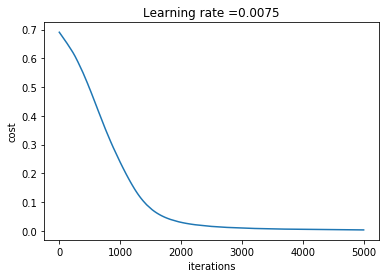

In [59]:
parameters, costs = L_layer_model_simple(x, y, layers_dims, iterations = iterations, log_every= log_every)

The loss calculated on the entire dataset decreases smoovely meaning that the gradient descent is implemented correctly.

# Real World Dataset (Dogs/Cats Classifier)
In this part the network will be applied to real world tasks such as photo classification. We'll train the network on 2,000 labeled images of cats and dogs and then evaluate it on 500 examples of test data.

### Load and Preprocess Images
Load all images into numpy arrays and resize them to $[32, 32, 3]$. Colored images have 3 RGB channels while black and white images have only 1 channel. This dataset contains only colored images and that's what will be loaded into our 3 separate datasets: **train_set, dev_set and test_set**. 
- Our network will be trained on train_set, then we'll verify how well it's doing on the dev_set in order to tweek our hyperparameters and improve performance. At the very end, when everything works well we'll test its final performance using test_set to make sure that our network doesn't overfeet train and dev sets.
- All images will be flattened into $[m, 3072]$ where $m$ is a number of images and $3072 = 32 x 32 x 3$ so that we can feed it into our neural network
- Then we'll normalize (scale) all pixels in our images by dividing them by max value a pixel can have (255) to help the network converge quicker. The reason for this is that if the input values are to high sigmoid activation function has hard time dealing with them and outputs very small numbers which result in tiny gradients during backpropagation and therefore slow down the learning process. (Look at the graph above showing sigmoid function). 

In [61]:
# Directories
TRAIN_DIR = 'input/train/'
TEST_DIR = "test/"

# Image size
ROWS, COLS, CHANNELS = 32, 32, 3

# Load the image directories into variables and split them into separate data sets.
img_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
img_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

train_images = img_dogs[:11000] + img_cats[:11000]
dev_images = img_dogs[11000:11750] + img_cats[11000:11750]
test_images = img_dogs[11750:12500] + img_cats[11750:12500]

# Randomly shuffle the images
random.shuffle(train_images), random.shuffle(dev_images), random.shuffle(test_images)

# Load the image from given directorie
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

# Load the images into 32 x 32 x 3 numpy arrays
def prep_data(images):
    count = len(images)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image
        if i%500 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

# Flatten the images with dimensions [32, 32, 3] into one row array [3072, 1]. (3072 = 32*32*3)
def flatten_images(data):
    m = data.shape[0]
    depth = data.shape[1]
    width = data.shape[2]
    height = data.shape[3]
    
    flatten_images = data.reshape(m, depth*width*height)
    return flatten_images

# Noramlize the images by dividing the pixels by the highest value they can be which is 255.
def normalize_images(images):
    return images / 255

# Create labels for the images
def create_labels(images):
    labels = []
    for i in images:
        if 'dog' in i:
            labels.append(1)
        else:
            labels.append(0)
    labels = np.array(labels, ndmin=2).T
    return labels


# Load images into datasets
train_set = normalize_images(flatten_images(prep_data(train_images)))
dev_set = normalize_images(flatten_images(prep_data(dev_images)))
test_set = normalize_images(flatten_images(prep_data(test_images)))

# Create labels
train_labels = create_labels(train_images)
dev_labels = create_labels(dev_images)
test_labels = create_labels(test_images)

print("Train set shape: {}, Train labels shape: {}".format(train_set.shape, train_labels.shape))
print("Dev set shape: {}, Dev labels shape: {}".format(dev_set.shape, dev_labels.shape))
print("Test set shape: {}, Test labels shape: {}".format(test_set.shape, test_labels.shape))

Train set shape: (22000, 3072), Train labels shape: (22000, 1)
Dev set shape: (1500, 3072), Dev labels shape: (1500, 1)
Test set shape: (1500, 3072), Test labels shape: (1500, 1)


**Show an Image**

Show an image of a dog with a label 1 (dog = 1, cat = 0).

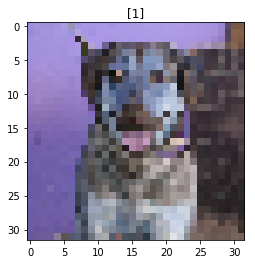

In [65]:
plt.imshow(train_set[131].reshape(32, 32, 3))
plt.title(train_labels[131])
plt.show()

### Build a model (mini-batch)
Training the network on let say 100.000 images at the same time requires a lot of computing power. Therefore to make it easier on our computer we implement mini-batching which divides the dataset into many samples of let's say 64 and then feed that into the neural network. Then we'll test our network's performance on a development set to see how well it generalizes to the images it has not seen before.
- Implemet mini-batches
- Implement test_model() fucntion

In [62]:
def get_batches(images, labels, batch_size):
    ''' Create a generator of images batches as a tuple (inputs, targets) '''
    
    n_batches = len(images) //batch_size
    
    # only full batches
    images = images[:n_batches*batch_size]
    
    for idx in range(0, len(images), batch_size):
        batch_inputs = images[idx:idx+batch_size]
        batch_labels = labels[idx:idx+batch_size]
        
        yield (np.array(batch_inputs).T , np.array(batch_labels, ndmin=2).T)

In [63]:
def test_model(AL, Y):
    # Number of examples
    m = Y.shape[1]
    correct = 0
    for i in range(m):
        if(AL[0,i] >= 0.5 and Y[0,i] == 1):
            correct += 1
            
        elif(AL[0,i] < 0.5 and Y[0,i] == 0):
            correct += 1
            
    prob = (correct / m) * 100
    return prob        

In [64]:
def L_layer_model_default(x, y, X_dev, Y_dev, layers_dims, epochs, batch_size, parameters=None, costs=None, dev_costs=None, learning_rate = 0.0075, log_every = 10):
    
    if parameters == None:
        parameters = initialize_parameters(layers_dims)
        costs = []
        dev_costs = []
     
    # Find out how many batches you'll get
    n_batches = len(x) //batch_size
    
    for epoch in range(epochs):
        batches = get_batches(x, y, batch_size)
        # total cost of all batches
        cost_batches = 0
        
        for i, (X, Y) in enumerate(batches):
            
            AL, caches = L_model_forward(X, parameters)

            cost = compute_cost(AL, Y)
            cost_batches += cost

            grads = L_model_backward(AL, Y, caches)

            parameters = update_parameters(parameters, grads, learning_rate)
        
        # Append the average cost over all batches in one epoch.
        costs.append(cost_batches / n_batches)
        
        # Development cost
        AL_dev, _ = L_model_forward(X_dev, parameters)
        dev_costs.append(compute_cost(AL_dev, Y_dev))
            
        if epoch % log_every == 0:
            AL_train, _ = L_model_forward(x.T, parameters)
            AL_test, _ = L_model_forward(X_dev, parameters)
            prob_train = test_model(AL_train, y.T)
            prob_test = test_model(AL_test, Y_dev)
            print("Epoch:", epoch, "Cost:", cost, "Train performance:", prob_train,"Dev performance:", prob_test)   

            
    # plot the cost and dev_cost
    plt.plot(np.squeeze(costs))
    plt.plot(np.squeeze(dev_costs))
    plt.ylabel('cost')
    plt.xlabel('epochs')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters, costs, dev_costs

### Train the Network
Train the network on 2000 images.

Epoch: 0 Cost: 0.693225184910056 Train performance: 50.9 Dev performance: 52.800000000000004
Epoch: 5 Cost: 0.670806752314321 Train performance: 59.599999999999994 Dev performance: 57.4
Epoch: 10 Cost: 0.6590607112037186 Train performance: 62.6 Dev performance: 61.199999999999996
Epoch: 15 Cost: 0.649450746494467 Train performance: 63.849999999999994 Dev performance: 62.6
Epoch: 20 Cost: 0.6413030445379146 Train performance: 64.14999999999999 Dev performance: 61.6
Epoch: 25 Cost: 0.633790694095125 Train performance: 64.9 Dev performance: 60.199999999999996
Epoch: 30 Cost: 0.6269717317954311 Train performance: 66.0 Dev performance: 60.0
Epoch: 35 Cost: 0.6203038082307795 Train performance: 67.0 Dev performance: 60.4
Epoch: 40 Cost: 0.6137290094150587 Train performance: 67.4 Dev performance: 60.199999999999996
Epoch: 45 Cost: 0.6073130937841942 Train performance: 68.15 Dev performance: 60.4


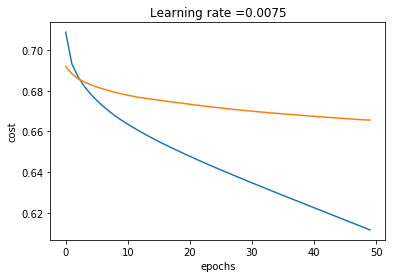

In [ ]:
layers_dims = [3072, 512, 1]
parameters, costs, dev_costs = L_layer_model_default(train_set[0:2000], train_labels[0:2000], 
                             dev_set[:500].T, dev_labels[:500].T, 
                             layers_dims, 
                             epochs = 50,
                             batch_size = 128,
                             parameters=None, 
                             costs=None,
                             dev_costs=None,
                             learning_rate = 0.0075, 
                             log_every=5)

**Analysis:**

Around the $1500th$ iteration the cost shown on the graph is extremaly wiggle. This is caused by exploding gradients. The weights keep increasing also causing the gradients to increase which then results in even greater change in weights. This continues until the weights overflow and become **Nan**.

In [ ]:
layers_dims = [3072, 512, 1]
parameters, costs, dev_costs = L_layer_model_default(train_set[0:22000], train_labels[0:22000], 
                             dev_set[:1500].T, dev_labels[:1500].T, 
                             layers_dims, 
                             epochs = 50,
                             batch_size = 128,
                             parameters=None, 
                             costs=None,
                             dev_costs=None,
                             learning_rate = 0.0075, 
                             log_every=5)

Epoch: 0 Cost: 0.6665126379967218 Train performance: 59.49545454545454 Dev performance: 58.733333333333334
Epoch: 5 Cost: 0.6346737693519932 Train performance: 63.131818181818176 Dev performance: 62.53333333333333
Epoch: 10 Cost: 0.6202168274962072 Train performance: 64.82727272727273 Dev performance: 63.6
Epoch: 15 Cost: 0.6091861955470892 Train performance: 66.4090909090909 Dev performance: 63.53333333333333
Epoch: 20 Cost: 0.6024695164202705 Train performance: 67.57272727272728 Dev performance: 64.2
Epoch: 25 Cost: 0.5980743156065162 Train performance: 68.33636363636364 Dev performance: 64.66666666666666
Epoch: 30 Cost: 0.5955915442354276 Train performance: 69.08636363636363 Dev performance: 64.86666666666666
Epoch: 35 Cost: 0.5936210314514458 Train performance: 69.57727272727273 Dev performance: 65.66666666666666


### Build a model (L2 norm)
The graph above shows that the loss function is extremaly wiggle. This happens because of something called exploding gradients resulting in large changes in loss from update to update. In deep multilayer neural networks, exploding gradients can result in an unstable network that at best cannot learn from the training data and at worst results in NaN weight values that can no longer be updated. 
- In order to deal with exploding gradients we'll implement L2 norm which applies penalty to the network's loss function for large weight values.
- Then we'll reduce batch_size to 32 (apparently it helps)

### Compute cost

Compute the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$

In [23]:
def compute_cost_L2(AL, Y, parameters, lambd):
    m = Y.shape[1]
    L = len(parameters) // 2
    sum_of_squared_weights = 0
    for l in range(1, L+1):
        sum_of_squared_weights =+ np.sum(np.square(parameters["W" + str(l)]))
        
    L2_regularization_cost = lambd * sum_of_squared_weights / (2*m)
    
    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T)) + L2_regularization_cost
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

### Backpropagation

In [24]:
def linear_backward_L2(dZ, cache, lambd):
    A_prev, W, b = cache
    m = A_prev.shape[1]
        
    if lambd == 0:
        dW = (1.0 / m) * np.dot(dZ, A_prev.T)
        db = (1.0 / m) * np.sum(dZ, axis=-1, keepdims=True)
        
    elif(lambd != 0):
        dW = (1.0 / m) * np.dot(dZ, A_prev.T) + ((lambd * W) / m)
        db = (1.0 / m) * np.sum(dZ, axis=-1, keepdims=True)
    
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [25]:
def linear_activation_backward_L2(dA, cache, lambd, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = dA * relu(activation_cache, True)
        
    elif activation == "sigmoid":
        dZ = dA * sigmoid(activation_cache, True)
        
    dA_prev, dW, db = linear_backward_L2(dZ, linear_cache, lambd)
    
    return dA_prev, dW, db    

In [26]:
def L_model_backward_L2(AL, Y, caches, lambd):
    L = len(caches)
    grads = {}
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward_L2(dAL, current_cache, 
                                                                                                     lambd, 
                                                                                                     activation = "sigmoid")
    
    for l in reversed(range(1, L)):
        current_cache = caches[l - 1]
        dA = grads["dA" + str(l+1)]
        grads["dA" + str(l)], grads["dW" + str(l)], grads["db" + str(l)] = linear_activation_backward_L2(dA, current_cache, 
                                                                                                     lambd,
                                                                                                     activation = "relu")
    return grads

### Update parameters

In [27]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [29]:
def L_layer_model_L2(x, y, X_dev, Y_dev, layers_dims, epochs, batch_size, parameters=None, costs=None, dev_costs=None, learning_rate = 0.0075, lambd=0.1, log_every = 10):
    
    if parameters == None:
        parameters = initialize_parameters(layers_dims)
        costs = []
        dev_costs = []
     
    # Find out how many batches you'll get
    n_batches = len(x) //batch_size
    
    for epoch in range(epochs):
        batches = get_batches(x, y, batch_size)
        # total cost of all batches
        cost_batches = 0
        
        for i, (X, Y) in enumerate(batches):
            
            AL, caches = L_model_forward(X, parameters)

            cost = compute_cost_L2(AL, Y, parameters, lambd)
            cost_batches += cost

            grads = L_model_backward_L2(AL, Y, caches, lambd)

            parameters = update_parameters(parameters, grads, learning_rate)
        
        # Append the average cost over all batches in one epoch.
        costs.append(cost_batches / n_batches)
        
        # Development cost
        AL_dev, _ = L_model_forward(X_dev, parameters)
        dev_costs.append(compute_cost(AL_dev, Y_dev))
            
        if epoch % log_every == 0:
            AL_train, _ = L_model_forward(x.T, parameters)
            AL_test, _ = L_model_forward(X_dev, parameters)
            prob_train = test_model(AL_train, y.T)
            prob_test = test_model(AL_test, Y_dev)
            print("Epoch:", epoch, "Cost:", cost, "Train performance:", prob_train,"Dev performance:", prob_test)
        
        

        

            
    # plot the cost and dev_cost
    plt.plot(np.squeeze(costs))
    plt.plot(np.squeeze(dev_costs))
    plt.ylabel('cost')
    plt.xlabel('epochs')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters, costs, dev_costs

Epoch: 0 Cost: 0.6722203739611752 Train performance: 57.95 Dev performance: 53.800000000000004
Epoch: 5 Cost: 0.6258911566414435 Train performance: 63.3 Dev performance: 59.599999999999994
Epoch: 10 Cost: 0.5956418555719657 Train performance: 65.3 Dev performance: 60.6
Epoch: 15 Cost: 0.5653199117679438 Train performance: 67.7 Dev performance: 62.2
Epoch: 20 Cost: 0.5359140281791771 Train performance: 68.95 Dev performance: 61.199999999999996
Epoch: 25 Cost: 0.5088105321420213 Train performance: 70.75 Dev performance: 62.2
Epoch: 30 Cost: 0.48182949094885646 Train performance: 72.25 Dev performance: 62.8
Epoch: 35 Cost: 0.4570587235573657 Train performance: 74.15 Dev performance: 62.8
Epoch: 40 Cost: 0.4364967073570635 Train performance: 75.6 Dev performance: 63.2
Epoch: 45 Cost: 0.41837452753998444 Train performance: 77.2 Dev performance: 62.6
Epoch: 50 Cost: 0.39748037132482567 Train performance: 78.85 Dev performance: 63.6
Epoch: 55 Cost: 0.3715733991799554 Train performance: 79.9 D

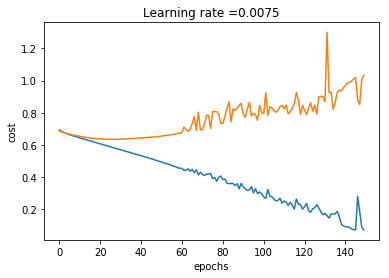

In [50]:
layers_dims = [3072, 256, 16, 1]
parameters, costs, dev_costs = L_layer_model_L2(train_set[0:2000], train_labels[0:2000], 
                             dev_set[:500].T, dev_labels[:500].T, 
                             layers_dims, 
                             epochs = 150,
                             batch_size = 32,
                             parameters=None, 
                             costs=None,
                             dev_costs=None,
                             learning_rate = 0.0075, 
                             lambd=0.03,
                             log_every=5)

### Dropout

In [33]:
def L_model_forward_with_dropout(X, parameters, keep_prob):
    L = len(parameters) // 2
    caches = []
    dropout_masks = []
    A = X
    
    for l in range(1, L):
        A_prev = A
        
        # Implement Dropout
        D = np.random.rand(A.shape[0], A.shape[1])
        D = D < keep_prob
        A = (A*D) / keep_prob # Shut down some neurons and scale the values that haven't been shut down
        dropout_masks.append(D) # Save dropout mask for backpropagation
        
        # Forward pass
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], activation="relu")
        caches.append(cache)
        
        
    
    # Implement dropout for last layer
    D = np.random.rand(A.shape[0], A.shape[1])
    D = D < keep_prob
    A = (A*D) / keep_prob
    dropout_masks.append(D)
    
    # Forward pass
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation="sigmoid")
    caches.append(cache)
    
    return AL, caches, dropout_masks

In [34]:
def L_model_backward_with_dropout(AL, Y, caches, dropout_masks, keep_prob):
    L = len(caches)
    grads = {}
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, 
                                                                                                  activation = "sigmoid")
    # Implement dropout
    current_mask = dropout_masks[-1]
    grads["dA" + str(L)] = (grads["dA" + str(L)] * current_mask) / keep_prob # apply mask and scale gradients for nodes that haven't beed shut down
    
    for l in reversed(range(1, L)):
        current_cache = caches[l - 1]
        dA = grads["dA" + str(l+1)]
        grads["dA" + str(l)], grads["dW" + str(l)], grads["db" + str(l)] = linear_activation_backward(dA, current_cache,
                                                                                                     activation = "relu")
        # Implement dropout
        current_mask = dropout_masks[l - 1]
        grads["dA" + str(l)] = (grads["dA" + str(l)] * current_mask) / keep_prob # apply mask and scale gradients for nodes that haven't beed shut down

    return grads

In [35]:
def L_layer_model_dropout(x, y, X_dev, Y_dev, layers_dims, epochs, batch_size, parameters=None, costs=None, dev_costs=None, learning_rate = 0.0075, keep_prob=0.5, log_every = 10):
    
    if parameters == None:
        parameters = initialize_parameters(layers_dims)
        costs = []
        dev_costs = []
     
    # Find out how many batches you'll get
    n_batches = len(x) //batch_size
    
    for epoch in range(epochs):
        batches = get_batches(x, y, batch_size)
        # total cost of all batches
        cost_batches = 0
        
        for i, (X, Y) in enumerate(batches):
            
            AL, caches, dropout_masks = L_model_forward_with_dropout(X, parameters, keep_prob)

            cost = compute_cost_L2(AL, Y, parameters, lambd)
            cost_batches += cost

            grads = L_model_backward_with_dropout(AL, Y, caches, dropout_masks, keep_prob)

            parameters = update_parameters(parameters, grads, learning_rate)
        
        # Append the average cost over all batches in one epoch.
        costs.append(cost_batches / n_batches)
        
        # Development cost
        AL_dev, _ = L_model_forward(X_dev, parameters)
        dev_costs.append(compute_cost(AL_dev, Y_dev))
            
        if epoch % log_every == 0:
            AL_train, _ = L_model_forward(x.T, parameters)
            AL_test, _ = L_model_forward(X_dev, parameters)
            prob_train = test_model(AL_train, y.T)
            prob_test = test_model(AL_test, Y_dev)
            print("Epoch:", epoch, "Cost:", cost, "Train performance:", prob_train,"Dev performance:", prob_test)
        
        

        

            
    # plot the cost and dev_cost
    plt.plot(np.squeeze(costs))
    plt.plot(np.squeeze(dev_costs))
    plt.ylabel('cost')
    plt.xlabel('epochs')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters, costs, dev_costs

Epoch: 0 Cost: 0.6721935231320255 Train performance: 55.45 Dev performance: 54.800000000000004
Epoch: 5 Cost: 0.6223458739252294 Train performance: 62.849999999999994 Dev performance: 60.0
Epoch: 10 Cost: 0.589909827769723 Train performance: 65.0 Dev performance: 61.199999999999996
Epoch: 15 Cost: 0.6301029922910829 Train performance: 66.64999999999999 Dev performance: 61.8
Epoch: 20 Cost: 0.5691489880076422 Train performance: 68.65 Dev performance: 62.6
Epoch: 25 Cost: 0.565324774117248 Train performance: 70.05 Dev performance: 63.4
Epoch: 30 Cost: 0.5278912864601727 Train performance: 71.25 Dev performance: 63.6
Epoch: 35 Cost: 0.49243629971123803 Train performance: 73.1 Dev performance: 63.2
Epoch: 40 Cost: 0.5039024956996578 Train performance: 74.4 Dev performance: 63.4
Epoch: 45 Cost: 0.44168445964046904 Train performance: 73.65 Dev performance: 62.0
Epoch: 50 Cost: 0.42503796465327426 Train performance: 76.95 Dev performance: 63.6
Epoch: 55 Cost: 0.44906371479830387 Train perform

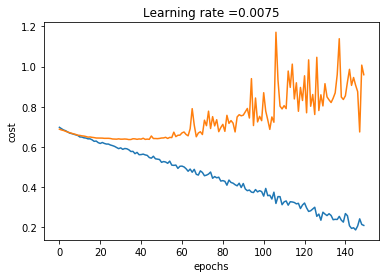

In [52]:
layers_dims = [3072, 256, 16, 1]
parameters, costs, dev_costs = L_layer_model_dropout(train_set[0:2000], train_labels[0:2000], 
                             dev_set[:500].T, dev_labels[:500].T, 
                             layers_dims, 
                             epochs = 150,
                             batch_size = 32,
                             parameters=None, 
                             costs=None,
                             dev_costs=None,
                             learning_rate = 0.0075, 
                             keep_prob=0.8,
                             log_every=5)